In [ ]:
!pip install holoviews

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [27]:
filename = "BBT_TEST.csv"
df = pd.read_csv(filename)

Create a NetworkX graph from the CSV data:

In [28]:
G = nx.DiGraph()

for _, row in df.iterrows():
    G.add_edge(row['Donor Node'], row['Dependent Node'], topo=row['Topo'])

Compute the degree of each node:

In [ ]:
degree_table = pd.DataFrame(G.degree(), columns=["Node", "Degree"])
print(degree_table)

To visualise the graph in Pyviz (using the library HoloViews) with node colors based on the "Sector" column:

In [ ]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

In [31]:
G = nx.DiGraph()

for _, row in df.iterrows():
    G.add_edge(row['Donor Node'], row['Dependent Node'], topo=row['Topo'])

# Assuming 'Sector' attribute is available in the DataFrame
sector = {node: df.loc[df['Donor Node'] == node, 'Sector'].iloc[0] for node in G.nodes}
nx.set_node_attributes(G, sector, 'sector')
unique_sectors = df['Sector'].unique().tolist()
color_mapping = {sector: color for sector, color in zip(unique_sectors, hv.plotting.util.cycle_colors(n=len(unique_sectors), colormap='Category20'))}
hv_graph = hv.Graph.from_networkx(G, nx.layout.spring_layout).opts(
    node_color='sector', node_cmap=color_mapping, edge_alpha=0.5, width=800, height=800
)
hv_graph

Analyse the primary impact and cascading impacts based on flood data:

In [35]:
def compute_impacts(G, flooded_nodes):
    primary_impact = set()
    secondary_impact = set()
    tertiary_impact = set()

    for node in flooded_nodes:
        if node in G:
            for successor in G.successors(node):
                topo_value = G[node][successor]['topo']
                if topo_value == 1:
                    primary_impact.add(successor)
                elif topo_value == 2:
                    continue
                else:
                    pass

            for primary_node in primary_impact:
                for successor in G.successors(primary_node):
                    topo_value = G[primary_node][successor]['topo']
                    if topo_value == 1:
                        secondary_impact.add(successor)
                    elif topo_value == 2:
                        continue
                    else:
                        pass

                for secondary_node in secondary_impact:
                    for successor in G.successors(secondary_node):
                        topo_value = G[secondary_node][successor]['topo']
                        if topo_value == 1:
                            tertiary_impact.add(successor)
                        elif topo_value == 2:
                            continue
                        else:
                            pass

    return primary_impact, secondary_impact, tertiary_impact

Plot the initial map:

In [ ]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color="blue")
plt.show()

Plot the affected nodes:

In [ ]:
def plot_affected_nodes(G, pos, impact):
    primary, secondary, tertiary = impact
    affected_nodes = primary | secondary | tertiary
    unaffected_nodes = set(G.nodes()) - affected_nodes

    nx.draw_networkx_nodes(G, pos, nodelist=unaffected_nodes, node_color="blue")
    nx.draw_networkx_nodes(G, pos, nodelist=affected_nodes, node_color="red")
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)

    plt.show()

plot_affected_nodes(G, pos, impact_2030)
plot_affected_nodes(G, pos, impact_2050)

Plot a result graph for all impacts comparing different scenarios:

In [ ]:
def calculate_resilience_performance(initial_count, impact_count):
    return (initial_count - impact_count) / initial_count * 100

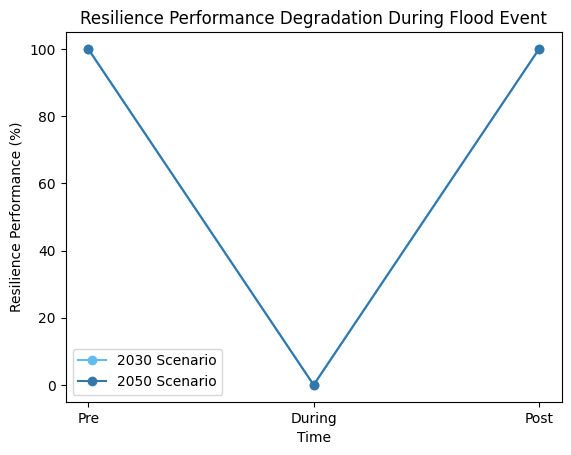

In [38]:
def plot_resilience_performance_line_graph(impact_2030, impact_2050):
    initial_count = len(G.nodes)

    total_impact_2030 = sum([len(x) for x in impact_2030])
    total_impact_2050 = sum([len(x) for x in impact_2050])

    resilience_performance_2030 = calculate_resilience_performance(initial_count, total_impact_2030)
    resilience_performance_2050 = calculate_resilience_performance(initial_count, total_impact_2050)

    scenarios = ["Pre", "During", "Post"]
    resilience_performance_2030_values = [100, resilience_performance_2030, 100]
    resilience_performance_2050_values = [100, resilience_performance_2050, 100]

    plt.plot(scenarios, resilience_performance_2030_values, color='#62BBEE', label="2030 Scenario", marker='o')
    plt.plot(scenarios, resilience_performance_2050_values, color='#3378AB', label="2050 Scenario", marker='o')

    plt.xlabel("Time")
    plt.ylabel("Resilience Performance (%)")
    plt.title("Resilience Performance Degradation During Flood Event")
    plt.legend()
    plt.show()

plot_resilience_performance_line_graph(impact_2030, impact_2050)

Display the results in a table:

In [39]:
def create_impact_table(impact_2030, impact_2050):
    primary_2030, secondary_2030, tertiary_2030 = [len(x) for x in impact_2030]
    primary_2050, secondary_2050, tertiary_2050 = [len(x) for x in impact_2050]

    impact_data = {
        "Primary Impact": [primary_2030, primary_2050],
        "Secondary Impact": [secondary_2030, secondary_2050],
        "Tertiary Impact": [tertiary_2030, tertiary_2050]
    }

    impact_df = pd.DataFrame(impact_data, index=["2030", "2050"])
    return impact_df

impact_table = create_impact_table(impact_2030, impact_2050)
print(impact_table)

      Primary Impact  Secondary Impact  Tertiary Impact
2030              92               310                1
2050              93               309                1
